# IMGCOL Submission
#### Hard_drive_corrupted
A guide to colorization of images Encoder Decoder based models

## Import Libraries
We will be using pytorch for this code

In [2]:
import torch
import os
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm.notebook import tqdm
from PIL import Image
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import torch.utils.model_zoo as model_zoo


## Dataset
The dataset contains 20,000 training images and 2000 validation images. There are 5001 test images which need to be automatically coloured. Each image is of dimensions `512*512*3` and contains a mix of images from different environments

In [3]:
path = '../input/colorization'
train_col = os.path.join(path,'train_col_images/train_col_images')
train_bw = os.path.join(path,'train_black_white_images-v2/train_black_white_images-v2')
val_col = os.path.join(path,'validation_col_images/validation_color_images-v2')
val_bw = os.path.join(path,'validation_bw/validation_black_white_images-v2')
test_bw = os.path.join(path,'test_bw_images/test_black_white_images-v2')
print(len(os.listdir(test_bw)))

5001


## Colorspace
Given Single Channel Input Grayscale images we want to get 3 channel RGB output.  
This problem can instead be tackled by converting Lab Color Space and treated as a Classification + Regression Problem. It contains the same amount of information but helps us remove the lightness component.   
This converts the problem into given L(or Grayscale) predict the values of `a` and `b`. `a` stands for red and blue and ranges between `[-128,127]` while `b` stands for green and yellow and ranges between `[-128,127]`

In [39]:
class GrayDataset(Dataset):
    def __init__(self, gray_path, color_path=None,):
        self.gray_path = gray_path
        self.color_path = color_path
        self.gray_imgs_paths = os.listdir(self.gray_path)
    
    def __len__(self):
        return len(self.gray_imgs_paths)
    
    def __getitem__(self,idx):
        gray_img = cv2.imread(f"{self.gray_path}/{self.gray_imgs_paths[idx]}", 0)
        gray_img = cv2.resize(gray_img, (256, 256))
        gray_img = gray_img[np.newaxis, :, :]
        gray_img = gray_img/255.0
        gray_img = torch.tensor(gray_img)
        if self.color_path:
            color_img = cv2.imread(f"{self.color_path}/{self.gray_imgs_paths[idx]}")
            color_img = cv2.cvtColor(color_img,cv2.COLOR_BGR2RGB)
            color_img = cv2.resize(color_img, (256, 256))
#             color_img = color_img/255.0
            img_lab = rgb2lab(color_img)
#             img_lab = cv2.cvtColor(color_img,cv2.COLOR_RGB2LAB)
#             img_lab = (img_lab+128)/255
#             img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
#           Normalization in Lab space
            img_lab = (img_lab - [0, 0, 0]) / [100, 110, 110]
            img_ab = img_lab[:,:,1:3]
            img_ab = torch.tensor(img_ab)
            color_img = torch.tensor(color_img)
            return gray_img,img_ab.permute(2,0,1)
        else:
            img_id = self.gray_imgs_paths[idx]
            return gray_img,img_id
        

train_class = GrayDataset(train_bw, train_col)
evens = list(range(500))
trainset_1 = torch.utils.data.Subset(train_class, evens)
# train_loader = torch.utils.data.DataLoader(train_class, batch_size=24, shuffle=True)
train_loader = torch.utils.data.DataLoader(trainset_1, batch_size=24, shuffle=True)

val_class = GrayDataset(val_bw, val_col)
valset_1 = torch.utils.data.Subset(val_class, evens)
# val_loader = torch.utils.data.DataLoader(val_class, batch_size=24, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset_1, batch_size=24, shuffle=True)


test_class = GrayDataset(test_bw)
small = list(range(200))
testset_1 = torch.utils.data.Subset(test_class, small)
# test_loader = torch.utils.data.DataLoader(test_class, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset_1, batch_size=8, shuffle=True)

In [40]:
def to_rgb(gray,ab):
    color_img = torch.cat((gray,ab),0).numpy()
    color_img = color_img.transpose((1,2,0))
#     color_img[:,:,0:1] = color_img[:,:,0:1]*100
#     color_img[:,:,1:3] = color_img[:,:,1:3]*255 - 128
#     color_img = color_img*[100, 255, 255] - [0, 128, 128]
    color_img = color_img*[100, 110, 110] - [0, 0, 0]
    color_img = lab2rgb(color_img.astype('float64'))
#     color_img = cv2.cvtColor(color_img.astype('uint8'),cv2.COLOR_LAB2RGB)
    return color_img

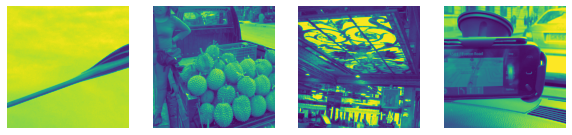

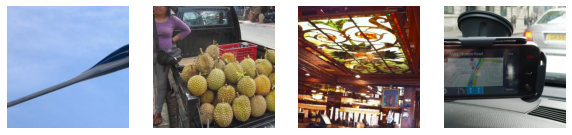

In [41]:
gray,ab = next(iter(val_loader))
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(gray[i].numpy().transpose(1,2,0).reshape((256,256)))
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    sh = to_rgb(gray[i],ab[i])
    plt.imshow(sh)

## Model
We follow this [SIGGRAPH Paper](https://richzhang.github.io/InteractiveColorization/). The model is basically an encoder decoder architecture. We perform regression on the values of `a and b` channel. The model also incorporates sparse user inputs into the colorization aspect. 
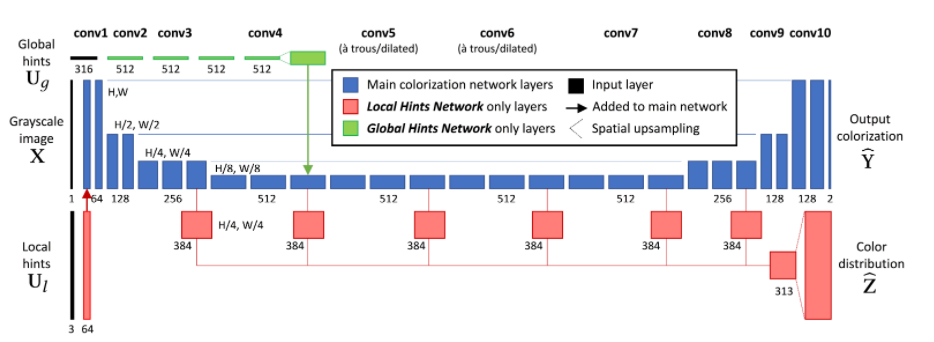
In the given model,the Local Hints uses the user input and tries to predict a color statistic. The Global Hints section tries to do the same but the user input here is global image color histogram. These are incorporated into the network. This is the classification part.  
This network has been pretrained on imagenet dataset.

In [8]:
class SIGGRAPHGenerator(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, classes=529):
        super(SIGGRAPHGenerator, self).__init__()

        
        self.model1 = nn.Sequential(nn.Conv2d(4,64,kernel_size=3,stride=1,padding=1,bias=True),
                                   nn.ReLU(True),
                                   nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(64))
        
        # add a subsampling operation

        # Conv2
        self.model2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.ReLU(True),
                                norm_layer(128))
        # add a subsampling layer operation

        # Conv3
        self.model3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    norm_layer(256))
        # add a subsampling layer operation

        # Conv4
        self.model4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    norm_layer(512))

        # Conv5
        self.model5=nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                norm_layer(512))

        # Conv6
        self.model6=nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                                nn.ReLU(True),
                                norm_layer(512))

        # Conv7
        self.model7=nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.ReLU(True),
                                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.ReLU(True),
                                norm_layer(512))

        # Conv7
        self.model8up=nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True))
        self.model3short8=nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True))

        self.model8=nn.Sequential(nn.ReLU(True),
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
                    nn.ReLU(True),
                    norm_layer(256))

        # Conv9
        self.model9up=nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True))
        self.model2short9=nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True))
        # add the two feature maps above        

        self.model9=nn.Sequential(nn.ReLU(True),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(True),
                norm_layer(128))

        # Conv10
        self.model10up=nn.Sequential(nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True))
        self.model1short10=nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True))
        # add the two feature maps above

        self.model10=nn.Sequential(nn.ReLU(True),
                    nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
                    nn.LeakyReLU(negative_slope=.2))

        # classification output
        self.model_class=nn.Sequential(nn.Conv2d(256, classes, kernel_size=1, padding=0, dilation=1, stride=1, bias=True))

        # regression output
        self.model_out=nn.Sequential(nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),
                        nn.Tanh())


        self.upsample4 = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear'))
        self.softmax = nn.Sequential(nn.Softmax(dim=1))

    def forward(self, input_A, input_B=None, mask_B=None):
        if(input_B is None):
            input_B = torch.cat((input_A*0, input_A*0), dim=1)
        if(mask_B is None):
            mask_B = input_A*0

        conv1_2 = self.model1(torch.cat((input_A,input_B,mask_B),dim=1))
        conv2_2 = self.model2(conv1_2[:,:,::2,::2])
        conv3_3 = self.model3(conv2_2[:,:,::2,::2])
        conv4_3 = self.model4(conv3_3[:,:,::2,::2])
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)
        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        return out_reg


In [45]:
class SIGGRAPHGenerator1(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, classes=529):
        super(SIGGRAPHGenerator1, self).__init__()

        # Conv1
        model1=[nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]
        # add a subsampling operation

        # Conv2
        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]
        # add a subsampling layer operation

        # Conv3
        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]
        # add a subsampling layer operation

        # Conv4
        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        # Conv5
        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        # Conv6
        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        # Conv7
        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        # Conv7
        model8up=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)]
        model3short8=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]

        model8=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[norm_layer(256),]

        # Conv9
        model9up=[nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True),]
        model2short9=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        # add the two feature maps above        

        model9=[nn.ReLU(True),]
        model9+=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model9+=[nn.ReLU(True),]
        model9+=[norm_layer(128),]

        # Conv10
        model10up=[nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True),]
        model1short10=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        # add the two feature maps above

        model10=[nn.ReLU(True),]
        model10+=[nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),]
        model10+=[nn.LeakyReLU(negative_slope=.2),]

        # classification output
        model_class=[nn.Conv2d(256, classes, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),]

        # regression output
        model_out=[nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),]
        model_out+=[nn.Tanh()]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8up = nn.Sequential(*model8up)
        self.model8 = nn.Sequential(*model8)
        self.model9up = nn.Sequential(*model9up)
        self.model9 = nn.Sequential(*model9)
        self.model10up = nn.Sequential(*model10up)
        self.model10 = nn.Sequential(*model10)
        self.model3short8 = nn.Sequential(*model3short8)
        self.model2short9 = nn.Sequential(*model2short9)
        self.model1short10 = nn.Sequential(*model1short10)

        self.model_class = nn.Sequential(*model_class)
        self.model_out = nn.Sequential(*model_out)

        self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='bilinear'),])
        self.softmax = nn.Sequential(*[nn.Softmax(dim=1),])

    def forward(self, input_A, input_B=None, mask_B=None):
        if(input_B is None):
            input_B = torch.cat((input_A*0, input_A*0), dim=1)
        if(mask_B is None):
            mask_B = input_A*0

        conv1_2 = self.model1(torch.cat((input_A,input_B,mask_B),dim=1))
        conv2_2 = self.model2(conv1_2[:,:,::2,::2])
        conv3_3 = self.model3(conv2_2[:,:,::2,::2])
        conv4_3 = self.model4(conv3_3[:,:,::2,::2])
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)
        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        return out_reg

In [54]:

model = SIGGRAPHGenerator1()
model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth',map_location='cpu',check_hash=True))


<All keys matched successfully>

## Loss
MSELoss is typically good enough for image regression. However we are dealing with a multimodal problem, i.e a grayscale input can have multiple output. For eg a same tshirt can be green as well as red. In these situations MSE can penalize very heavily leading to suboptimal results. The paper works around it using SmoothL1Loss or Huber Loss to tackle this problem. It is a robust estimator and doesnt penalize multimodal outputs as harshly.

In [43]:
# Setting up optimizer & loss
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=0.001)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

## Training
We finetune the model on our dataset.

In [47]:
use_gpu = torch.cuda.is_available()

if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

def train_epoch(model,optimizer,criterion,train_loader,device):
    train_loss = 0
    model.train()
    for i,(input_gray,target) in enumerate(tqdm(train_loader)):
        if device:
            input_gray,target = input_gray.cuda().float(),target.cuda().float()
        pred = model(input_gray)
#         print(pred.shape,target.shape)
        loss = criterion(pred.float(),target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/len(train_loader.dataset)

def val_epoch(model,val_loader,device):
    val_loss = 0

    model.eval()
    for i,(input_gray,target) in enumerate(tqdm(val_loader)):
        if device:
            input_gray,target = input_gray.cuda().float(),target.cuda().float()
        pred = model(input_gray)
        loss = criterion(pred.float(),target)
        val_loss += loss.item()
    return val_loss/len(val_loader.dataset) 

train_losses = []
val_losses = []
best_loss = np.inf
checkpoint_path = './checkpoint.pth'

for epoch in tqdm(range(2)):
    train_loss = train_epoch(model,optimizer,criterion,train_loader,use_gpu)
    with torch.no_grad():
        val_loss = val_epoch(model,val_loader,use_gpu)
    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving Checkpoint")
        torch.save(model.state_dict(),checkpoint_path)
    print(f'Epoch = {epoch}, Train Loss = {train_loss}, Val Loss={val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Saving Checkpoint
Epoch = 0, Train Loss = 0.001114019826054573, Val Loss=0.001029520485550165


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch = 1, Train Loss = 0.0011024562828242778, Val Loss=0.0010699426755309104


In [48]:
os.makedirs('test_color_images',exist_ok=True)
model.load_state_dict(torch.load(checkpoint_path))

model.to('cuda')
model.eval()
cols=[]
with torch.no_grad():
  for i, (input_gray, img_id) in enumerate(tqdm(test_loader)):
    predictions = model(input_gray.cuda().float())
    for n, prediction in enumerate(predictions):
#       prediction = prediction.detach().cpu().numpy().transpose(1 , 2, 0)
      col_img = to_rgb(input_gray[n].detach().cpu(),prediction.detach().cpu())
      col_img = (col_img*255).astype('uint8')
      col_img = cv2.resize(col_img,(512,512))
      cols.append(col_img)
      col_img = cv2.cvtColor(col_img,cv2.COLOR_RGB2BGR)
      
      cv2.imwrite(f"test_color_images/{img_id[n]}", col_img)

  0%|          | 0/25 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 935 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5558 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 18603 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3287 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5009 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarn

## Results

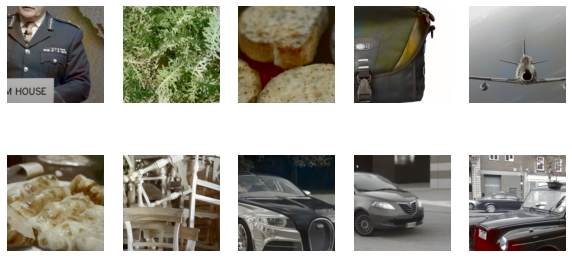

In [53]:
indices = np.random.randint(200,size=10)
plt.figure(figsize=(10,5))
for k,i in enumerate(indices):
    plt.subplot(2,5,k+1)
    plt.axis('off')
    plt.imshow(cols[i])

In [71]:
# !rm -rf submission.zip
!zip -qr submission.zip ./test_color_images
!rm -rf test_color_images
!rm -rf checkpoint.pth

In [ ]:
plt.imshow(col_img)

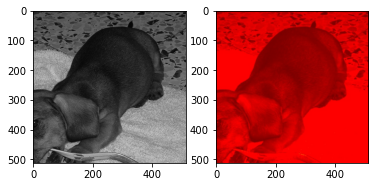

In [19]:
n = np.random.randint(100)
k = os.listdir('test_color_images')
lp = cv2.imread(os.path.join(test_bw,k[n]))
lp = cv2.cvtColor(lp,cv2.COLOR_BGR2RGB)
s = cv2.imread('test_color_images/'+k[n])
s = cv2.cvtColor(s,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(lp)
plt.subplot(1,2,2)
plt.imshow(s)

In [77]:
!du -sh submission.zip

293M	submission.zip


In [ ]:
# cv2.imwrite('test_color_images/'+img_id[n],col_img)